In [63]:
import re
import nltk
import json

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
from typing import List, Dict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Представление и предобработка текстовых данных в виде последовательностей

1.1 Представьте первое предложение из строки `text` как последовательность из индексов слов, входящих в это предложение

In [3]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [4]:
def text2vector(text: str, bag: Dict[str, int]) -> List[int]:
    patched_words = text.lower().split(" ")
    return [bag[word] for word in patched_words]

In [5]:
words_set = set(map(lambda x: x.lower(), text.split(" ")))
bag_router_dict = {word : index for index, word in enumerate(words_set)}
bag_router_dict

{'pytorch.': 0,
 'supported': 1,
 'that': 2,
 'stable': 3,
 'is': 4,
 'the': 5,
 'for': 6,
 'run': 7,
 'version': 8,
 'most': 9,
 'available': 10,
 'c++': 11,
 'and': 12,
 'tested': 13,
 'install': 14,
 'preferences': 15,
 'only': 16,
 'currently': 17,
 'represents': 18,
 'note': 19,
 'select': 20,
 'libtorch': 21,
 'of': 22,
 'command.': 23,
 'your': 24}

In [6]:
text2vector(text, bag_router_dict)

[20,
 24,
 15,
 12,
 7,
 5,
 14,
 23,
 3,
 18,
 5,
 9,
 17,
 13,
 12,
 1,
 8,
 22,
 0,
 19,
 2,
 21,
 4,
 16,
 10,
 6,
 11]

1.2 Представьте первое предложение из строки `text` как последовательность векторов, соответствующих индексам слов. Для представления индекса в виде вектора используйте унитарное кодирование. В результате должен получиться двумерный тензор размера `количество слов в предложении` x `количество уникальных слов`

In [7]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [8]:
text = text.lower()
text

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c++'

In [9]:
#Формируем dict с ассоциацией слово -> таргет (индекс)
target = list(set(nltk.word_tokenize(text.replace(".", ""))))
word2index = {word: count for count, word in enumerate(target)}
word2index

{'supported': 0,
 'that': 1,
 'stable': 2,
 'is': 3,
 'pytorch': 4,
 'the': 5,
 'command': 6,
 'for': 7,
 'run': 8,
 'version': 9,
 'most': 10,
 'available': 11,
 'c++': 12,
 'and': 13,
 'tested': 14,
 'install': 15,
 'preferences': 16,
 'only': 17,
 'currently': 18,
 'represents': 19,
 'note': 20,
 'select': 21,
 'libtorch': 22,
 'of': 23,
 'your': 24}

In [10]:
#Берем первое предложение для процессинга
sentence_str = nltk.sent_tokenize(text)[0].replace(".", "")
sentence_str

'select your preferences and run the install command'

In [11]:
#Получаем список слов в предложении
words_list = nltk.word_tokenize(sentence_str)
words_list

['select', 'your', 'preferences', 'and', 'run', 'the', 'install', 'command']

In [12]:
#Создаем нулевой вектор по нашей длине
vectors = torch.zeros(len(words_list), len(target))
vectors

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])

In [13]:
#Получаем список, содержащий индекс слова и его закодированную цифру
indices = [(index, word2index[word]) for index, word in enumerate(words_list)]
indices

[(0, 21), (1, 24), (2, 16), (3, 13), (4, 8), (5, 5), (6, 15), (7, 6)]

In [14]:
#Формируем маску, по которой будем вставлять единицу в тензор
current_mask = list(zip(*indices))
current_mask

[(0, 1, 2, 3, 4, 5, 6, 7), (21, 24, 16, 13, 8, 5, 15, 6)]

In [15]:
#Получаем итоговый результат 
vectors[current_mask] = 1
vectors

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])

In [16]:
indices_old = indices

1.3 Решите задачу 1.2, используя модуль `nn.Embedding`

In [17]:
#чтоб случайного фактора не было и рандомных значений
torch.manual_seed(0)

In [18]:
len(target)

25

In [19]:
#Создаем объект эмбединга
embeds = nn.Embedding(num_embeddings=len(target), embedding_dim=len(target))
embeds

Embedding(25, 25)

In [20]:
indices = torch.tensor([word2index[w] for w in nltk.word_tokenize(sentence_str)])
indices

tensor([21, 24, 16, 13,  8,  5, 15,  6])

In [21]:
assert list(map(lambda x: x[1], indices_old)) == list(map(lambda x: x.item(), indices))

In [22]:
#Получаем эмбединги по нашим индексам
embeds(indices)

tensor([[ 1.2532, -0.4445,  0.8185, -0.8180,  0.3603, -1.6146, -2.4734,  0.0362,
         -0.3422, -0.3817, -0.0569,  0.8436,  0.6829,  3.3944, -1.6688,  0.5109,
         -0.2860,  0.3351,  1.1719,  1.2955,  0.8909, -0.4898, -1.1727, -0.6870,
         -2.3349],
        [ 0.1483,  2.4187,  1.3279, -0.2639,  0.3645,  2.5440, -2.6895,  2.4426,
          0.0104, -0.5644, -0.9184, -0.7496, -0.0949,  1.1009,  1.3105, -0.2928,
          0.4181, -0.1695, -2.1749,  0.7202,  0.2854,  0.2290,  1.2833, -1.3792,
          1.4042],
        [-0.7645,  0.2408,  0.1664, -2.2318,  1.3892, -0.5023,  1.6797, -1.0240,
          1.6859, -1.2177,  0.7650,  1.1971, -0.7128, -0.0656,  2.2050,  1.7852,
         -0.0118,  0.9797, -1.0661,  1.7720, -0.2793, -0.2769,  0.7489, -0.6435,
         -0.9518],
        [ 1.0077,  1.0046, -0.4335, -1.2426,  1.2846,  0.2438,  0.5304, -0.0145,
         -2.2357,  1.4660, -1.2191,  0.6442,  3.9300, -0.1244,  0.2953,  0.3827,
         -0.5497, -0.9940,  1.3459,  1.9457, -1.2904

## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса> 
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта: 
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [23]:
#2.1 Считать файл surnames/surnames.csv.
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/surnames/surnames.csv")
df

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian
...,...,...
10975,Quraishi,Arabic
10976,Innalls,English
10977,Król,Polish
10978,Purvis,English


In [24]:
#2.2 Закодировать национальности числами, начиная с 0.
#Используем LabelEncoder

#создаем объект класса LabelEncoder из библиотеки Scikit-learn и сохраняем в переменной label_encoder. (Объект LabelEncoder позволяет преобразовывать категориальные данные в числовые метки.)
label_encoder = LabelEncoder()

#далее создаем новый столбец "label" в DataFrame "df", который будет содержать числовые метки, соответствующие значениям в столбце "nationality".
#Метод fit_transform() из объекта label_encoder преобразует значения в столбце "nationality" из категориальных строк в числовые метки и сохраняет результат в новом столбце "label" DataFrame "df". 
#В результате каждое уникальное значение в столбце "nationality" будет иметь свой уникальный числовой эквивалент в столбце "label".
df["label"] = label_encoder.fit_transform(df["nationality"])

#выводим содержимое DataFrame
df

,surname,nationality,label
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14
...,...,...,...
10975,Quraishi,Arabic,0
10976,Innalls,English,4
10977,Król,Polish,12
10978,Purvis,English,4


In [25]:
#Кол-во классов:
#далее мы вычисляем количество уникальных значений в столбце "label"
#unique() - возвращаем массив всех уникальных значений в столбце "label", т.е. все числовые метки, которые были присвоены категориальным данным.
#set() - преобразуем этот массив в множество, чтобы удалить дубликаты.
#len() - возвращаем длину этого множества, т.е. количество уникальных числовых меток в столбце "label".
len(set(df["label"].unique()))

18

In [26]:
#проверяем корректность преобразования категориальных данных в числовые метки, выполненного с помощью объекта LabelEncoder.
#наш код проверяет, что количество уникальных значений в множестве числовых меток, возвращенном с помощью set(df["label"].unique()), соответствует длине массива уникальных значений, возвращенных с помощью label_encoder.classes_.
#и если это условие выполняется, то преобразование категориальных данных в числовые метки должно было выполнено корректно.
#(Функция assert используется для проверки выполнения условия. Если условие не выполняется, то возникает исключение AssertionError и программа останавливается с сообщением об ошибке.)
assert len(set(df["label"].unique())) == len(label_encoder.classes_)

In [28]:
#2.4 Реализовать класс Vocab (токен = символ)
# добавьте в словарь специальный токен <PAD> с индексом 0
# при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута max_seq_len

class Vocab:
    
    #Строка, которая символизирует отступ
    PAD = "<PAD>"

    def __init__(self, series):
        
        
        #Нужен, чтоб хранить уникальные слова
        items_set = set()
        
        #Штука, которая нужна, чтоб определить макс вектор, чтоб потом заполнить pad ами
        max_len = 0
        
        #Формируем список слов + ищем max_len
        for word in map(str.lower, series):
            items_set.update(word)
            
            if len(word) > max_len:
                max_len = len(word)
                
        #Общий алфавит
        self.alphabet = [self.PAD, *items_set]
        
        self.max_len = max_len
        
        #Формируем транслятор слово -> таргет
        self.word_to_number_router = {item: number for number, item in enumerate(self.alphabet)}
        
    def decode(self, indices):
        """Метод декодинга"""
        
        #Маска по индексам-заглушкам
        mask = indices == self.word_to_number_router[self.PAD]
        
        #Сами индексы заглушек
        pad_indices = torch.nonzero(mask, as_tuple=True)[0]
        
        if len(pad_indices) != 0:
            indices = indices[:pad_indices[0]]  # отрезаем служебные символы
        
        return "".join(self.alphabet[i] for i in indices)
        
    def encode(self, word):
        """Метод енкодинга"""
        
        #Список индексов
        indices_list = [self.word_to_number_router[item] for item in word]
        
        #Индекс заглушки
        pad_index = self.word_to_number_router[self.PAD]
        
        #Разница, на которую надо дополнить слово
        len_diff = self.max_len - len(indices_list)
        
        # дополняем до одинакового размера индексом служебного символа
        indices_list +=  len_diff * [pad_index]
        
        return torch.tensor(indices_list, dtype=torch.long)

    def __repr__(self) -> str:
        return json.dumps(self.word_to_number_router, ensure_ascii=False)
    
    def __len__(self):
          return len(self.word_to_number_router)

In [29]:
vocab = Vocab(df["surname"])

In [30]:
vocab.word_to_number_router

{'<PAD>': 0,
 'd': 1,
 'ä': 2,
 'c': 3,
 'f': 4,
 '1': 5,
 '-': 6,
 'ú': 7,
 'v': 8,
 'b': 9,
 'a': 10,
 's': 11,
 'ù': 12,
 '/': 13,
 'g': 14,
 'e': 15,
 'ê': 16,
 'j': 17,
 'ó': 18,
 'u': 19,
 'ã': 20,
 'ą': 21,
 'ń': 22,
 'ö': 23,
 'w': 24,
 'n': 25,
 'ç': 26,
 'ñ': 27,
 't': 28,
 'ż': 29,
 'k': 30,
 'õ': 31,
 ':': 32,
 'ì': 33,
 'p': 34,
 'o': 35,
 'ü': 36,
 'z': 37,
 'è': 38,
 'm': 39,
 'l': 40,
 'q': 41,
 'á': 42,
 'é': 43,
 'i': 44,
 "'": 45,
 'ł': 46,
 'ò': 47,
 'x': 48,
 'à': 49,
 'r': 50,
 'ß': 51,
 'ś': 52,
 'y': 53,
 'í': 54,
 'h': 55}

In [31]:
len(vocab)

56

In [32]:
print(vocab)

{"<PAD>": 0, "d": 1, "ä": 2, "c": 3, "f": 4, "1": 5, "-": 6, "ú": 7, "v": 8, "b": 9, "a": 10, "s": 11, "ù": 12, "/": 13, "g": 14, "e": 15, "ê": 16, "j": 17, "ó": 18, "u": 19, "ã": 20, "ą": 21, "ń": 22, "ö": 23, "w": 24, "n": 25, "ç": 26, "ñ": 27, "t": 28, "ż": 29, "k": 30, "õ": 31, ":": 32, "ì": 33, "p": 34, "o": 35, "ü": 36, "z": 37, "è": 38, "m": 39, "l": 40, "q": 41, "á": 42, "é": 43, "i": 44, "'": 45, "ł": 46, "ò": 47, "x": 48, "à": 49, "r": 50, "ß": 51, "ś": 52, "y": 53, "í": 54, "h": 55}


In [33]:
#проверим с дополнениями PADами
#энкодинг
test_str = "test"
encode_result = vocab.encode(test_str)
encode_result

tensor([28, 15, 11, 28,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [34]:
#декодинг
decode_result = vocab.decode(encode_result)
decode_result

'test'

In [35]:
assert test_str == decode_result

In [36]:
#проверим без дополнений PADами
#энкодинг
test_str = "test"* 5
encode_result = vocab.encode(test_str)
encode_result

tensor([28, 15, 11, 28, 28, 15, 11, 28, 28, 15, 11, 28, 28, 15, 11, 28, 28, 15,
        11, 28])

In [37]:
#декодинг
decode_result = vocab.decode(encode_result)
decode_result

'testtesttesttesttest'

In [38]:
assert test_str == decode_result

In [39]:
#2.5 Реализовать класс SurnamesDataset
# метод __getitem__ возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>
# длина каждой такой последовательности должна быть одинаковой и равной vocab.max_seq_len. Чтобы добиться этого, дополните последовательность справа индексом токена <PAD> до нужной длины
class SurnamesDatasetIndices(Dataset):
    def __init__(self, X, y, vocab):
            self.X = X
            self.y = y
            self.vocab = vocab

    def processing(self, surname):
        res = [self.vocab.word_to_number_router[token] for token in surname]
        if len(res) != self.vocab.max_len: 
            res.extend([self.vocab.word_to_number_router["<PAD>"]]*(self.vocab.max_len-len(res)))    
        return res
    
    def __len__(self):
        return len(self.X)
  
    def __getitem__(self, idx):
        return torch.LongTensor(self.processing(self.X.iloc[idx])), self.y.iloc[idx]

In [40]:
class SurnamesDatasetOnehot(Dataset):
    def __init__(self, X, y, vocab):
            self.X = X
            self.y = y
            self.vocab = vocab
            
    def processing(self, surname):
        res = [nn.functional.one_hot(torch.arange(0, len(self.vocab)))[self.vocab.word_to_number_router[token]] for token in surname]
        while len(res) < self.vocab.max_len:
            res.append(nn.functional.one_hot(torch.arange(0, len(self.vocab)))[self.vocab.word_to_number_router["<PAD>"]])
        return torch.stack(res)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.processing(self.X.iloc[idx])), self.y.iloc[idx]

In [41]:
#2.3 Разбить датасет на обучающую и тестовую выборку
X = df['surname'].str.lower()
y = df['label']
n_classes = y.nunique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
df

,surname,nationality,label
0,Woodford,English,4
1,Coté,French,5
2,Kore,English,4
3,Koury,Arabic,0
4,Lebzak,Russian,14
...,...,...,...
10975,Quraishi,Arabic,0
10976,Innalls,English,4
10977,Król,Polish,12
10978,Purvis,English,4


In [42]:
torch.manual_seed(0)

In [43]:
X_train

8996         leese
7868       evdakov
6109      severins
5417           zhu
5194        copley
           ...    
4859     terranova
3264          ruiz
9845         gagin
10799    crossland
2732        hoteev
Name: surname, Length: 8784, dtype: object

In [44]:
y_train

8996      4
7868     14
6109      3
5417      1
5194      4
         ..
4859      9
3264     16
9845     14
10799     4
2732     14
Name: label, Length: 8784, dtype: int64

In [45]:
train_dataset = SurnamesDatasetIndices(X_train, y_train, vocab)
test_dataset = SurnamesDatasetIndices(X_test, y_test, vocab)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 8784
Test dataset: 2196


In [46]:
train_dataset_onehot = SurnamesDatasetOnehot(X_train, y_train, vocab)
test_dataset_onehot = SurnamesDatasetOnehot(X_test, y_test, vocab)
train_loader_onehot = DataLoader(train_dataset_onehot, batch_size=128, shuffle=True)
test_loader_onehot = DataLoader(test_dataset_onehot, batch_size=128, shuffle=True)
print(f"Train dataset: {len(train_dataset_onehot)}")
print(f"Test dataset: {len(test_dataset_onehot)}")

Train dataset: 8784
Test dataset: 2196


In [47]:
#2.6. Обучить классификатор.
# Для преобразования последовательности индексов в последовательность векторов используйте nn.Embedding. Рассмотрите два варианта:
#  когда токен представляется в виде унитарного вектора и модуль nn.Embedding не обучается
#  когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль nn.Embedding обучается
# Используйте одномерные свертки и пулинг (nn.Conv1d, nn.MaxPool1d)
#  обратите внимание, что nn.Conv1d ожидает на вход трехмерный тензор размерности (batch, embedding_dim, seq_len)
class SurnameModel(nn.Module):
    def __init__(self, embed_num, embed_dim, classes_num, seq_len, use_embed=True):
        super(SurnameModel, self).__init__()

        self.embed_dim = embed_dim
        self.use_embed = use_embed
        self.seq_len = seq_len
        
        if self.use_embed:
            self.embed = nn.Embedding(embed_num, embed_dim)
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64, classes_num)

    def forward(self, x):
        if self.use_embed:
            x = self.embed(x)
        # print(x.shape)
        x = x.reshape(len(x), self.embed_dim, self.seq_len).type(torch.FloatTensor)
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x, _ = x.max(dim=-1)

        return self.fc1(x)

In [51]:
#используем SurnamesDatasetOneHot
model = SurnameModel(
    len(vocab), len(vocab), n_classes, vocab.max_len, use_embed=False
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

losses_plt = []
val_loss_plt = []

for epoch in range(n_epochs):
    print(f"\n-------------------------------\nEpoch {epoch+1}")
    epoch_loss = 0
    for X_batch, y_batch in train_loader_onehot:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader_onehot:
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch).item()
            acc = accuracy_score(
                y_batch, predictions.argmax(dim=1).cpu().detach()
            ).item()
            
            train_loss = epoch_loss / len(train_loader)
            
            val_loss += loss
            val_acc += acc

            print(
                f"Training loss: {train_loss:>7f} val_loss: {val_loss:>7f}"
            )
    val_loss_plt.append(loss)
    losses_plt.append(train_loss)


-------------------------------
Epoch 1
Training loss: 2.303617 val_loss: 2.120545
Training loss: 2.303617 val_loss: 4.233297
Training loss: 2.303617 val_loss: 6.425376
Training loss: 2.303617 val_loss: 8.632074
Training loss: 2.303617 val_loss: 10.870218
Training loss: 2.303617 val_loss: 13.171686
Training loss: 2.303617 val_loss: 15.307151
Training loss: 2.303617 val_loss: 17.434554
Training loss: 2.303617 val_loss: 19.540849
Training loss: 2.303617 val_loss: 21.738057
Training loss: 2.303617 val_loss: 23.906198
Training loss: 2.303617 val_loss: 26.067714
Training loss: 2.303617 val_loss: 28.297296
Training loss: 2.303617 val_loss: 30.439110
Training loss: 2.303617 val_loss: 32.577837
Training loss: 2.303617 val_loss: 34.728623
Training loss: 2.303617 val_loss: 36.718646
Training loss: 2.303617 val_loss: 39.214416

-------------------------------
Epoch 2
Training loss: 2.097405 val_loss: 1.910163
Training loss: 2.097405 val_loss: 3.942185
Training loss: 2.097405 val_loss: 6.015831
T

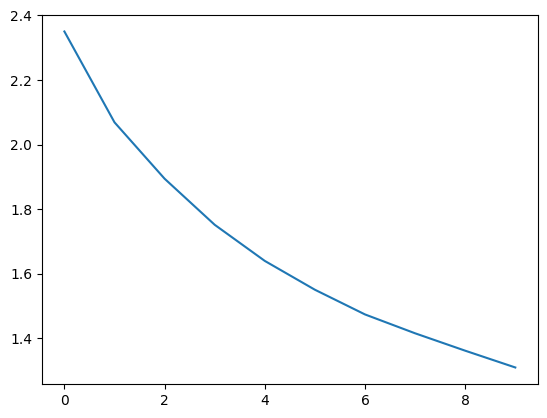

In [49]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(len(losses_plt)), losses_plt)

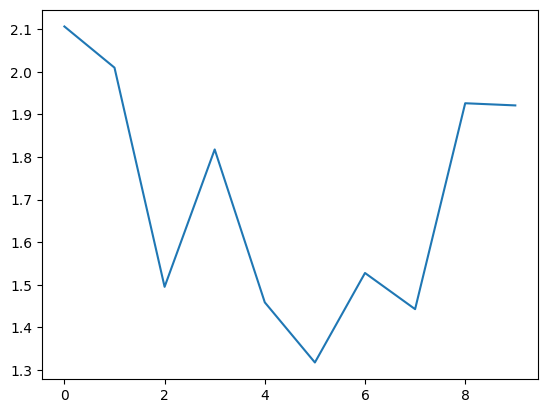

In [50]:
plt.plot(torch.arange(len(val_loss_plt)), val_loss_plt)

In [52]:
#2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. 
#Для каждой фамилии выводить 3 наиболее вероятных предсказания.
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

test_loader_onehot_2 = DataLoader(
    test_dataset_onehot, batch_size=len(test_dataset_onehot), shuffle=True
)
X_batch, y_batch = next(iter(test_loader_onehot_2))
predictions = model(X_batch).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       330
           1       0.38      0.56      0.45        32
           2       0.39      0.08      0.13        87
           3       0.33      0.02      0.04        49
           4       0.55      0.88      0.68       572
           5       0.14      0.03      0.04        38
           6       0.53      0.26      0.35       117
           7       0.50      0.26      0.34        27
           8       0.00      0.00      0.00        39
           9       0.40      0.49      0.44       120
          10       0.69      0.61      0.65       153
          11       0.00      0.00      0.00         8
          12       1.00      0.04      0.07        27
          13       0.00      0.00      0.00         9
          14       0.77      0.75      0.76       502
          15       0.00      0.00      0.00        23
          16       0.00      0.00      0.00        46
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# Проверяем работу модели на наших данных
names_list = [
    "Demenchuk",
    "Baranov",
    "Fogel",
    "Newman"
]

targets_list = ["Russian","Russian", "German", "English"]

for name, target in zip(map(lambda x: x.lower(), names_list), targets_list):
    x = torch.LongTensor(train_dataset_onehot.processing(name)).unsqueeze(0)
    output = model(x).cpu().detach().numpy()
    predictions = output.argsort()[0][-3:][::-1]
    predictions_names = label_encoder.inverse_transform(predictions)
    print(f"Surname : {name}")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts names: {predictions_names}\n")

Surname : demenchuk
True    : Russian
Predicts: [14  4 12]
Predicts names: ['Russian' 'English' 'Polish']

Surname : baranov
True    : Russian
Predicts: [14  4  2]
Predicts names: ['Russian' 'English' 'Czech']

Surname : fogel
True    : German
Predicts: [4 9 5]
Predicts names: ['English' 'Italian' 'French']

Surname : newman
True    : English
Predicts: [4 2 9]
Predicts names: ['English' 'Czech' 'Italian']



In [54]:
#используем OneHot
model = SurnameModel(len(vocab), 30, n_classes, vocab.max_len, use_embed=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

losses_plt = []
val_loss_plt = []

for epoch in range(n_epochs):
    print(f"\n-------------------------------\nEpoch {epoch+1}")
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch).item()
            acc = accuracy_score(
                y_batch, predictions.argmax(dim=1).cpu().detach()
            ).item()
            
            train_loss = epoch_loss / len(train_loader)
            
            val_loss += loss
            val_acc += acc
            print(
                f"Training loss: {train_loss:>7f} val_loss: {val_loss:>7f}"
            )
    val_loss_plt.append(loss)
    losses_plt.append(train_loss)


-------------------------------
Epoch 1
Training loss: 2.152228 val_loss: 1.784964
Training loss: 2.152228 val_loss: 3.840508
Training loss: 2.152228 val_loss: 5.736606
Training loss: 2.152228 val_loss: 7.843234
Training loss: 2.152228 val_loss: 9.531550
Training loss: 2.152228 val_loss: 11.490921
Training loss: 2.152228 val_loss: 13.470773
Training loss: 2.152228 val_loss: 15.411937
Training loss: 2.152228 val_loss: 17.328085
Training loss: 2.152228 val_loss: 19.181583
Training loss: 2.152228 val_loss: 21.269930
Training loss: 2.152228 val_loss: 23.237136
Training loss: 2.152228 val_loss: 25.197743
Training loss: 2.152228 val_loss: 27.153448
Training loss: 2.152228 val_loss: 28.963575
Training loss: 2.152228 val_loss: 30.976113
Training loss: 2.152228 val_loss: 32.906573
Training loss: 2.152228 val_loss: 34.809253

-------------------------------
Epoch 2
Training loss: 1.799917 val_loss: 1.874840
Training loss: 1.799917 val_loss: 3.558446
Training loss: 1.799917 val_loss: 5.137635
Tr

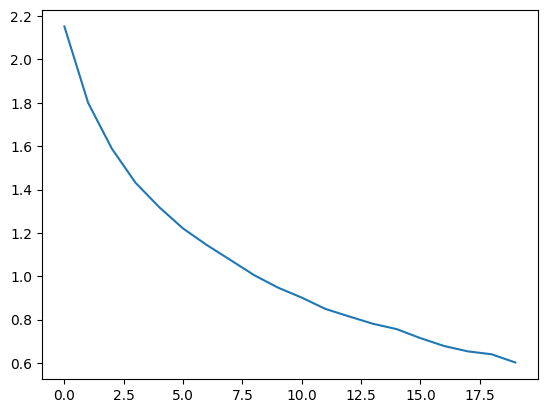

In [55]:
plt.plot(torch.arange(len(losses_plt)), losses_plt)

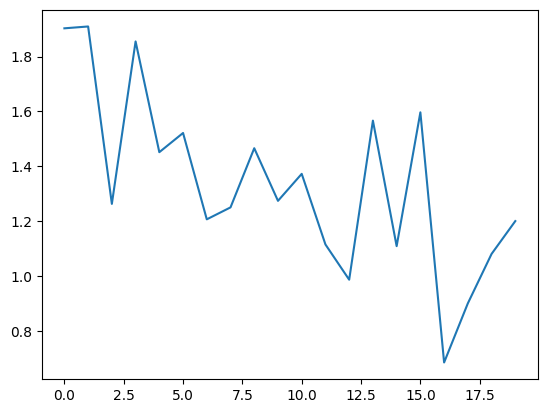

In [56]:
plt.plot(torch.arange(len(val_loss_plt)), val_loss_plt)

In [57]:
test_loader_2 = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader_2))
predictions = model(X_batch).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       330
           1       0.54      0.78      0.64        32
           2       0.50      0.15      0.23        87
           3       0.40      0.24      0.30        49
           4       0.63      0.86      0.73       572
           5       0.29      0.05      0.09        38
           6       0.62      0.36      0.45       117
           7       0.69      0.33      0.45        27
           8       0.75      0.23      0.35        39
           9       0.58      0.55      0.56       120
          10       0.80      0.76      0.78       153
          11       0.00      0.00      0.00         8
          12       0.50      0.04      0.07        27
          13       0.00      0.00      0.00         9
          14       0.77      0.85      0.81       502
          15       0.00      0.00      0.00        23
          16       0.36      0.26      0.30        46
          17       0.67    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
# Проверяем работу модели на наших данных
names_list = [
    "Demenchuk",
    "Baranov",
    "Fogel",
    "Newman"
]

targets_list = ["Russian","Russian", "German", "English"]

for name, target in zip(map(lambda x: x.lower(), names_list), targets_list):
    x = torch.LongTensor(train_dataset.processing(name)).unsqueeze(0)
    output = model(x).cpu().detach().numpy()
    predictions = output.argsort()[0][-3:][::-1]
    predictions_names = label_encoder.inverse_transform(predictions)
    print(f"Surname : {name}")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts names: {predictions_names}\n")

Surname : demenchuk
True    : Russian
Predicts: [14  6  2]
Predicts names: ['Russian' 'German' 'Czech']

Surname : baranov
True    : Russian
Predicts: [14  9  2]
Predicts names: ['Russian' 'Italian' 'Czech']

Surname : fogel
True    : German
Predicts: [ 4 14  2]
Predicts names: ['English' 'Russian' 'Czech']

Surname : newman
True    : English
Predicts: [4 6 8]
Predicts names: ['English' 'German' 'Irish']



## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [64]:
#3.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
# токен = слово
# данные для обучения в датасете представляются в виде последовательности индексов токенов
# словарь создается на основе только обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен <UNK>
# добавьте предобработку текста

#читаем данные с файлов
def file_reader(path) -> list:
    data = []
    with open(path) as f:
        for line in f.readlines():
            if line is not None:
                data.append(line)
    return data       

In [65]:
reviews_negative = file_reader("/content/drive/MyDrive/Colab Notebooks/polarity/negative_reviews.txt")
labels_negative = np.zeros(shape=len(reviews_negative), dtype=int)
labels_negative[-1]

0

In [66]:
len(reviews_negative)

5331

In [67]:
len(labels_negative)

5331

In [68]:
reviews_positive = file_reader("/content/drive/MyDrive/Colab Notebooks/polarity/positive_reviews.txt")
labels_positive = np.zeros(shape=len(reviews_positive), dtype=int)
labels_positive.fill(1)
labels_positive[-1]

1

In [69]:
len(reviews_positive)

5331

In [70]:
len(labels_positive)

5331

In [71]:
reviews = reviews_negative + reviews_positive
labels = np.concatenate((labels_negative, labels_positive), axis=0)

In [72]:
len(reviews)

10662

In [73]:
len(labels)

10662

In [74]:
n_classes = 2
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)

In [75]:
class Vocab:
    def __init__(self, data, unk_token: str = "<UNK>"):
        self.max_seq_len = 0
        tokens = set()
        for item in data:
            words = [word for word in word_tokenize(self.preprocess_text(item))]
            if len(words) > self.max_seq_len:
                self.max_seq_len = len(words)
            tokens.update(words)
        if unk_token is not None:
            tokens.add(unk_token)
        self.idx_to_token = dict(enumerate(tokens, 1))
        self.idx_to_token[0] = "<PAD>"
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

    def preprocess_text(self, text):
        return re.sub(r"[^a-zA-Z,!?\.]", " ", text.lower())

In [76]:
class ReviewsDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def to_indices(self, review):
        seq = [
            self.vocab.token_to_idx[token]
            if token in self.vocab.token_to_idx.keys()
            else self.vocab.token_to_idx["<PAD>"]
            for token in word_tokenize(review)
        ]
        if len(seq) < self.vocab.max_seq_len:
            seq.extend(
                [self.vocab.token_to_idx["<PAD>"]] * (self.vocab.max_seq_len - len(seq))
            )
        else:
            seq = seq[: self.vocab.max_seq_len]
        return torch.LongTensor(seq)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.to_indices(self.X[idx]), self.y[idx]

In [77]:
vocab = Vocab(X_train)
print(vocab.vocab_len)

16368


In [78]:
train_dataset = ReviewsDataset(X_train, y_train, vocab)
test_dataset = ReviewsDataset(X_test, y_test, vocab)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [79]:
#3.2. Обучите классификатор.
# Для преобразования последовательности индексов в последовательность векторов используйте nn.Embedding
#  подберите адекватную размерность вектора эмбеддинга:
#  модуль nn.Embedding обучается
# Используйте одномерные свертки и пулинг (nn.Conv1d, nn.MaxPool1d)
#  обратите внимание, что nn.Conv1d ожидает на вход трехмерный тензор размерности (batch, embedding_dim, seq_len)
class ReviewModel(nn.Module):
    def __init__(self, embed_num, embed_dim, classes_num, seq_len, use_embed=True):
        super(ReviewModel, self).__init__()

        self.embed_dim = embed_dim
        self.use_embed = use_embed
        self.seq_len = seq_len
        if self.use_embed:
            self.embed = nn.Embedding(embed_num, embed_dim)
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=256, kernel_size=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64, classes_num)

    def forward(self, x):
        if self.use_embed:
            x = self.embed(x)

        x = x.reshape(len(x), self.embed_dim, self.seq_len).type(torch.FloatTensor)
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x, _ = x.max(dim=-1)

        return self.fc1(x)

In [80]:
model = ReviewModel(vocab.vocab_len, 180, n_classes, vocab.max_seq_len, use_embed=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
n_epochs = 20

losses_plt = []
val_loss_plt = []

for epoch in range(n_epochs):
    print(f"\n-------------------------------\nEpoch {epoch+1}")
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch).item()
            acc = accuracy_score(
                y_batch, predictions.argmax(dim=1).cpu().detach()
            ).item()
            
            train_loss = epoch_loss / len(train_loader)
            val_loss += loss
            val_acc += acc
            print(
                f"Training loss: {train_loss:>7f} val_loss: {val_loss:>7f}"
            )
            
    val_loss_plt.append(loss)
    losses_plt.append(train_loss)


-------------------------------
Epoch 1
Training loss: 0.725259 val_loss: 0.713486
Training loss: 0.725259 val_loss: 1.441846
Training loss: 0.725259 val_loss: 2.169858
Training loss: 0.725259 val_loss: 2.893047
Training loss: 0.725259 val_loss: 3.620548
Training loss: 0.725259 val_loss: 4.338111
Training loss: 0.725259 val_loss: 5.066967
Training loss: 0.725259 val_loss: 5.792242
Training loss: 0.725259 val_loss: 6.493328
Training loss: 0.725259 val_loss: 7.202235
Training loss: 0.725259 val_loss: 7.884042
Training loss: 0.725259 val_loss: 8.580047
Training loss: 0.725259 val_loss: 9.304958
Training loss: 0.725259 val_loss: 9.985581
Training loss: 0.725259 val_loss: 10.666090
Training loss: 0.725259 val_loss: 11.390405
Training loss: 0.725259 val_loss: 12.090725

-------------------------------
Epoch 2
Training loss: 0.700339 val_loss: 0.696563
Training loss: 0.700339 val_loss: 1.434928
Training loss: 0.700339 val_loss: 2.128156
Training loss: 0.700339 val_loss: 2.841552
Training los

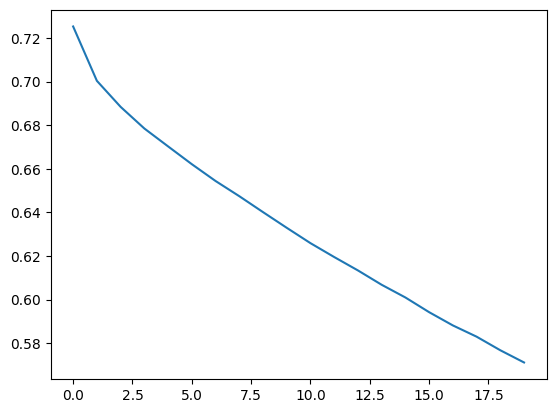

In [81]:
plt.plot(torch.arange(len(losses_plt)), losses_plt)

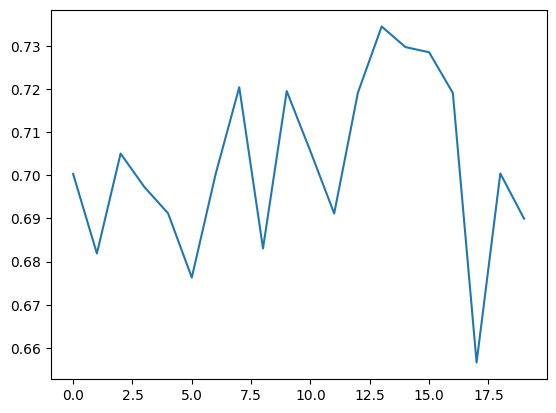

In [82]:
plt.plot(torch.arange(len(val_loss_plt)), val_loss_plt)

In [83]:
#3.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, 
#прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
# Целевое значение accuracy на валидации - 70+%
test_loader_2 = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
X_batch, y_batch = next(iter(test_loader_2))
predictions = model(X_batch).argmax(dim=1).cpu().detach()
print(classification_report(y_batch, predictions))

              precision    recall  f1-score   support

           0       0.51      0.53      0.52      1022
           1       0.55      0.52      0.54      1111

    accuracy                           0.53      2133
   macro avg       0.53      0.53      0.53      2133
weighted avg       0.53      0.53      0.53      2133



In [84]:
reviews_list = [
    """WOW! this was amazing!
normally i don’t do reviews but i’m just so blown away. from the casting to the acting to the set design to the plot and storyline, wednesday has completely left me speechless in the best way! i grew up watching the addams family movies and loving them for how weird and odd and endearing they were, this fits right in.
spoilers from here on just in case anyone hasn’t seen it! please please PLEASE go watch it, i promise you won’t be disappointed :)
    """,

    
"""This is a poor CW teen drama show. The quirkiness of the family is gone and in its stead is a dramatic mystery with relationship woes and attempts at suspenseful foreshadowing. While Thing is animated wonderfully, the prosthetics are far below par for even for a budget TV show, and animation for anything they plan to show for less than a minute is of a painful quality. The characters are rewritten in what seems like an attempt to make them fit with a teen drama dynamic. Rather than Morticia and Wednesday's loving yet at times adversarial relationship that still comes across as being very close to each other, they've cranked the adversarial part to 11 and turned both Gomez and Morticia into a type of "The adults you must rebel against". With this you no longer have the Addams family vs. The world, but rather Wednesday and her band of misfits Vs. The non understanding adults and the mean kids at school (I.E. Every Teen Drama). Speaking of her family, we also have Pugsly. Pugsly and Wednesday have always gotten into shared antics with Wednesday usually coming out on top. These were ways to highlight both of their near invulnerability while also having fun and showing their sadistic side in a cooky and zany way. Well, now Pugsly is instead this squeamish incapable child, who is mostly just used as a catalyst to have Wednesday unleash her wrath upon someone. """,
]


targets_list = ["Positive", "Negative"]
targets_dict = {1:"Positive", 0: "Negative"}


for review, target in zip(reviews_list, targets_list):

    x = train_dataset.to_indices(review).unsqueeze(0)
    predictions = model(x).argmax(dim=1).cpu().detach()
    predictions_str = targets_dict[predictions.item()]
    
    print(f"Review: \n{review[:100]}..")
    print(f"True    : {target}")
    print(f"Predicts: {predictions}")
    print(f"Predicts string: {predictions_str}\n")

Review: 
WOW! this was amazing!
normally i don’t do reviews but i’m just so blown away. from the casting to t..
True    : Positive
Predicts: tensor([0])
Predicts string: Negative

Review: 
This is a poor CW teen drama show. The quirkiness of the family is gone and in its stead is a dramat..
True    : Negative
Predicts: tensor([1])
Predicts string: Positive

